# Network Science
## Project: Social Network Analysis (VK)

* Student: Majid Sohrabi
* Program: Data Science

## Imports

In [16]:
import requests
import random
import numpy as np
import matplotlib.pyplot as plt
plt.xkcd()
import networkx as nx
import math
%matplotlib inline
import scipy.io
import scipy.stats
import seaborn as sns
import scipy.spatial as spt
from IPython.display import SVG
import pandas as pd
import matplotlib.image as mpimg
from typing import Dict, List
from networkx.algorithms import community
from sklearn.cluster import KMeans
from collections import Counter
import matplotlib.patches as mpatches
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable
from scipy.stats import kstest
from sklearn.linear_model import LinearRegression
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.csgraph import reverse_cuthill_mckee

## Read the (.gexf) file

In [17]:
G = nx.read_gexf('vk-friends-MS.gexf').to_undirected()

## Your Network Summary

Tasks:

1.   Network source and preprocessing (whether API was used, removing redundant information, do not forget to remove yourself (!) from ego-network).
2.   Node/Edge attributes.
3.   Size, Order.
4.   Diameter, radius.
5.   Clustering Coefficient (global, average local, histogram of locals).
6.   Average path length (+histogram).
7.   Degree distribution, fitting models and coefficient from regression/MLE/KS-test.
8.   Gorgeous network layout.

1. The information extracted from a (VK) profile (.gexf). The node itself is not in the file (After extracting gigantic componnet). Removing redundent information in the following

In [18]:
def delete_unnecessary_attrs(graph, *attrs):
    for node in graph.nodes:
        d_copy = list(graph.nodes[node])
        for key in d_copy:
            if key in attrs:
                del(graph.nodes[node][key])
    return graph

delete_unnecessary_attrs(G, 'nickname', 'photo_50', 'screen_name')

Extract Gigantic Component

In [19]:
cc = [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
print('Connected Component Discription:')
print("")
for c in Counter(cc):
  print('{} connected components ({} elements)'.format(Counter(cc)[c], c))


def select_gygantic_component(g: nx.Graph) -> nx.Graph:
    node_list = sorted(nx.connected_components(g), key = len, reverse=True)
    gg = node_list[0]
    len(node_list)
    for i in range(len(node_list) - 1):
        g.remove_nodes_from(node_list[i+1])
    return g

gig_component = G.copy()
gig_component = select_gygantic_component(gig_component)

Connected Component Discription:

1 connected components (93 elements)
1 connected components (6 elements)
4 connected components (3 elements)
6 connected components (2 elements)
48 connected components (1 elements)


2. Node/edge attributes

In [20]:
def node_and_edge_attributes(graph):
    node_attrs = set([attr for node in graph.nodes for attr in graph.nodes[node].keys()])
    edge_attrs = set([attr for edge in graph.edges for attr in graph.edges[edge].keys()])
    print("Node attributes :", node_attrs)
    print("Edge attributes :", edge_attrs)
    
node_and_edge_attributes(G)

Node attributes : {'bdate', 'sex', 'label', 'first_name', 'last_name', 'relation'}
Edge attributes : {'id'}


Basic Statistics
3.  Size, Order
4.  Diameter, Radious

In [21]:
print("Number of nodes:", len(G.nodes))
print("Number of edges:", len(G.edges))
print('Diameter: ', nx.diameter(gig_component))
print('Radius: ', nx.radius(gig_component))
print('Average shortest path length: ', nx.average_shortest_path_length(gig_component))
print('Average clustering coefficient: ', nx.average_clustering(gig_component))

Number of nodes: 171
Number of edges: 528
Diameter:  7
Radius:  4
Average shortest path length:  2.9046283309957923
Average clustering coefficient:  0.5573608817776979


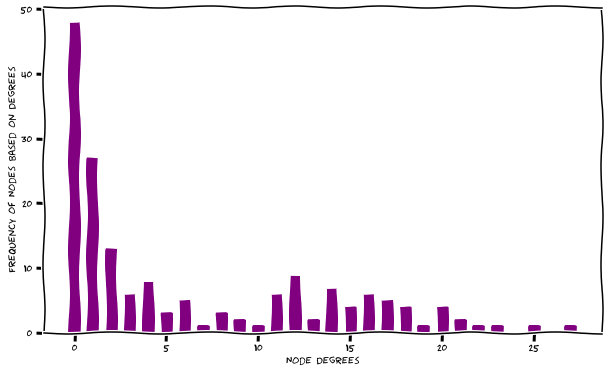

In [22]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
degree_count = {}
for key in degree_sequence:
    if key not in degree_count:
        degree_count[key] = 1
    else:
        degree_count[key] += 1

node_degree, node_numbers = list(degree_count.values()), list(degree_count.keys())
plt.figure(figsize=(10, 6))
plt.bar(node_numbers, node_degree, color='purple', width=0.6)
plt.xlabel("Node Degrees")
plt.ylabel("Frequency of Nodes Based on Degrees")
plt.show()

5. Clustering Coefficient (global, average local, histogram of locals).

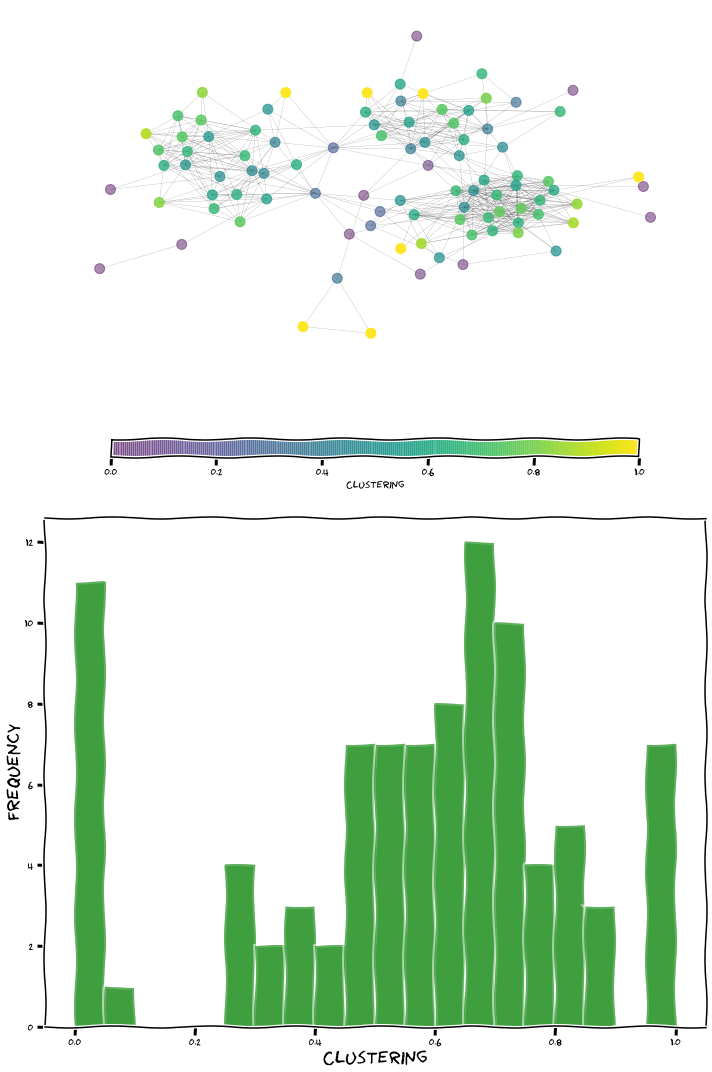

In [23]:
def customized_color(name_cmap, alpha):
  cmap = plt.get_cmap(name_cmap)
  custom_cmap = cmap(np.arange(cmap.N))
  custom_cmap[:,-1] = np.linspace(alpha, 1, cmap.N)
  custom_cmap = ListedColormap(custom_cmap)
  return custom_cmap

def pos_layout(g):
  df = pd.DataFrame(index=g.nodes(), columns=g.nodes())
  for row, data in nx.shortest_path_length(g):
      for col, dist in data.items():
          df.loc[row,col] = dist

  df = df.fillna(df.max().max())
  return df


cluster_coef = nx.clustering(gig_component)
cmap = customized_color('viridis', 0.45)
norm = plt.Normalize(0, max(cluster_coef.values()))
node_colors = [cmap(norm(cluster_coef[node])) for node in gig_component.nodes]
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 15))

df = pos_layout(gig_component)

pos = nx.kamada_kawai_layout(gig_component, dist=df.to_dict())
nx.draw(gig_component, 
        node_color=node_colors, 
        ax=ax1,
        pos=pos, 
        node_size=100, 
        width=0.1)
fig.colorbar(ScalarMappable(cmap=cmap, norm=norm), 
             label='Clustering', 
             shrink=0.8, 
             ax=ax1,
             aspect=30,
             orientation="horizontal")
ax1.tick_params(labelsize=25) 

ax1.margins(0.1,0.1)
ax2.hist(cluster_coef.values(), bins=20,alpha=0.5, color='green')
ax2.set_xlabel('Clustering', fontsize=18)
ax2.set_ylabel('Frequency', fontsize=18)

plt.tight_layout()
plt.show()

6.   Average Path Length (+ histogram)

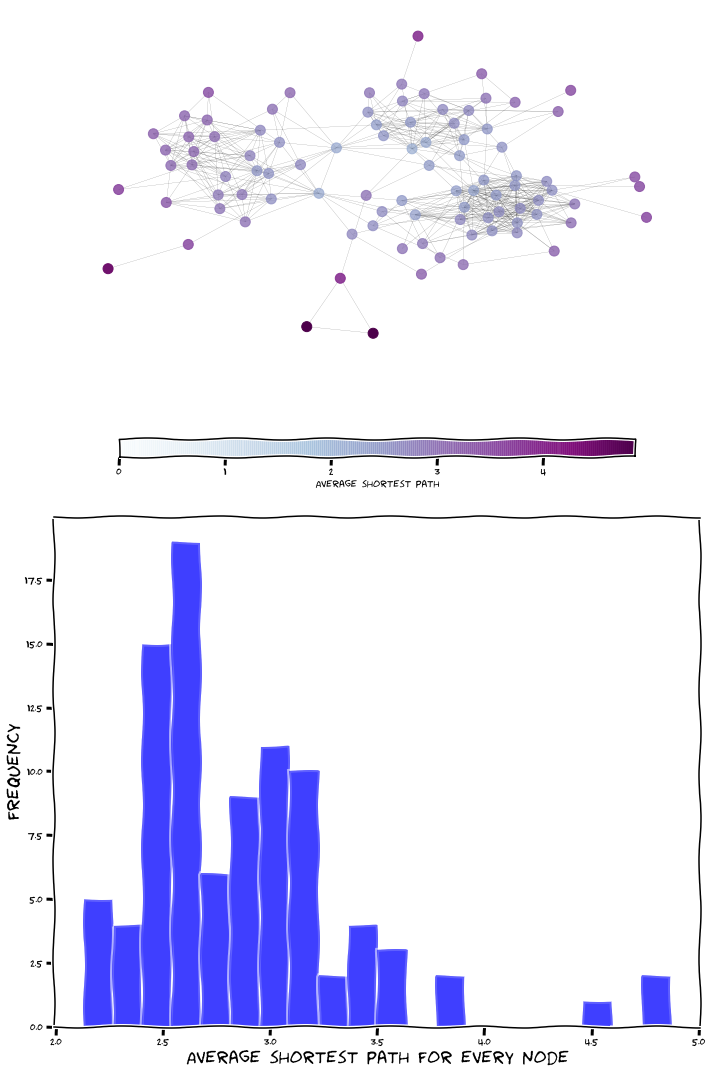

In [24]:
path_lens = {}
for node, path_len in nx.all_pairs_shortest_path_length(gig_component):
  path_means = np.mean(list(path_len.values()))
  path_lens[node] = path_means

cmap = customized_color('BuPu', 0.45)

norm = plt.Normalize(0, max(path_lens.values()))
node_colors = [cmap(norm(path_lens[node])) for node in gig_component.nodes]
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 15))

pos = nx.kamada_kawai_layout(gig_component, dist=df.to_dict())
nx.draw(gig_component, 
        node_color=node_colors, 
        ax=ax1,
        pos=pos, 
        node_size=100, 
        width=0.1)
fig.colorbar(ScalarMappable(cmap=cmap, norm=norm), 
             label='Average shortest path', 
             shrink=0.8, 
             ax=ax1,
             aspect=30,
             orientation="horizontal")
ax1.tick_params(labelsize=25) 

ax1.margins(0.1,0.1)
ax2.hist(path_lens.values(), bins=20,alpha=0.5, color='blue')
ax2.set_xlabel('Average shortest path For every node', fontsize=18)
ax2.set_ylabel('Frequency', fontsize=18)

plt.tight_layout()
plt.show()

7.   Degree distribution, fitting models and coefficient from regression/MLE/KS-test.

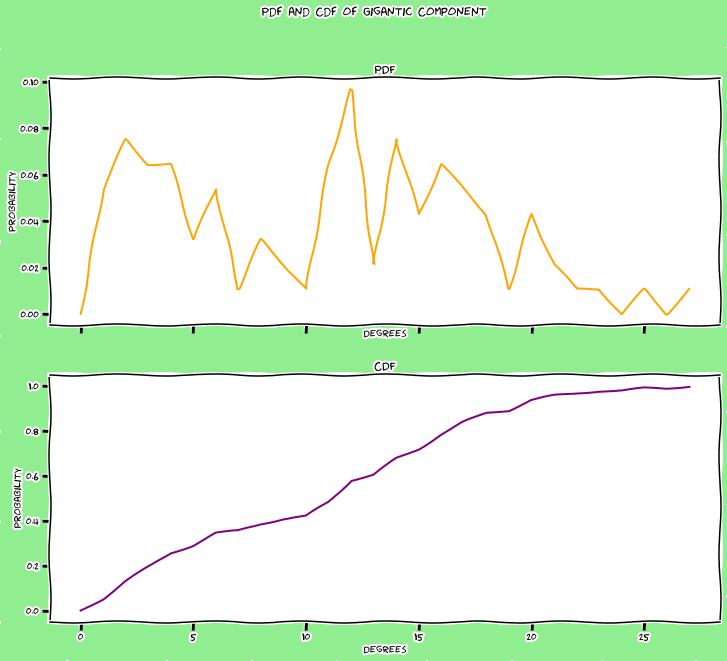

In [25]:
def gigantic_component_pdf(graph):
    return [deg_freq/len(graph.nodes) for deg_freq in nx.degree_histogram(graph)]

def gigantic_component_cdf(graph):
    pdfs = gigantic_component_pdf(graph)
    return np.cumsum(pdfs)

pdf = gigantic_component_pdf(gig_component)
cdf = gigantic_component_cdf(gig_component)

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(12, 10), facecolor='lightgreen')
ax[0].plot(pdf, color='orange')
ax[0].set_title('PDF')
ax[0].set_xlabel('Degrees')
ax[0].set_ylabel('Probability')

ax[1].plot(cdf, color='purple')
ax[1].set_title('CDF')
ax[1].set_xlabel('Degrees')
ax[1].set_ylabel('Probability')
plt.suptitle("Pdf and Cdf of Gigantic Component")
plt.show()

Log Scale

Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does n

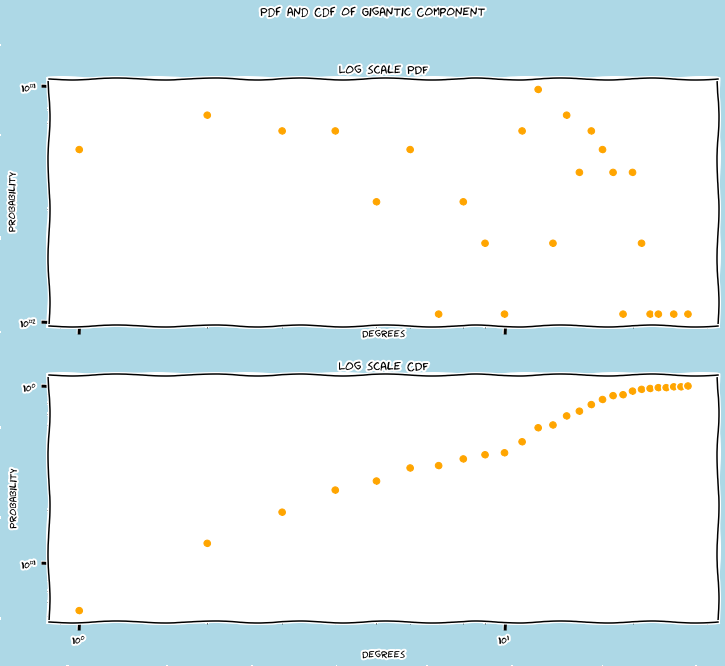

In [26]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(12, 10), facecolor='lightblue')
ax[0].loglog(np.arange(0, len(pdf)),
             pdf,
             color='orange',
             marker='o',
             linestyle='None')
ax[0].set_title('Log scale PDF')
ax[0].set_xlabel('Degrees')
ax[0].set_ylabel('Probability')

ax[1].loglog(np.arange(0, len(cdf)),
             cdf,
             color='orange',
             marker='o',
             linestyle='None')
ax[1].set_title('Log scale CDF')
ax[1].set_xlabel('Degrees')
ax[1].set_ylabel('Probability')
plt.suptitle("Pdf and Cdf of Gigantic Component")
plt.show()

In [27]:
def power_law_pdf(x, alpha=3.5, x_min=1):
    C = (alpha - 1) / x_min ** (1 - alpha)
    return C * x ** (-alpha)

def power_law_cdf(x, alpha=3.5, x_min=1):
    F_x = (x_min / x) ** (alpha-1)
    return 1 - F_x

def mle_power_law_params(degree_sequence):
    best_kstest = None
    sorted_x_train = np.sort(degree_sequence)
    x_mins = range(int(np.min(sorted_x_train)), int(np.max(sorted_x_train)))
    for i in range(len(x_mins)):
        x_min = x_mins[i]
        x_train = sorted_x_train[sorted_x_train >= x_min]
        alpha = 1 + len(x_train) * np.sum(np.log(x_train / x_min))**(-1)
        ks_test = kstest(x_train, lambda x:power_law_cdf(x, alpha, x_min))[0]
        
        if (best_kstest is None): # making sure it runs atleast once
            best_alpha, best_x_min, best_kstest = alpha, x_min, ks_test
        elif (best_kstest > ks_test):
            best_alpha, best_x_min, best_kstest = alpha, x_min, ks_test
      
    return best_alpha, best_x_min

def alpha_log_bins(x_train, bins):
    log_bins = np.logspace(np.log10(x_train.min()), np.log10(x_train.max()), bins)
    histogram = np.histogram(x_train, log_bins, density=True)
    density = histogram[0][np.where(histogram[0] != 0)]
    density = np.log(density / len(x_train))
    bin_centers = np.log((histogram[1][1:] + histogram[1][:-1]) / 2)
    bin_centers = bin_centers[np.where(histogram[0] != 0)].reshape(-1, 1)
    model = LinearRegression()
    model.fit(bin_centers, density)
    return abs(np.squeeze(model.coef_))

<Figure size 864x720 with 0 Axes>

Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does n

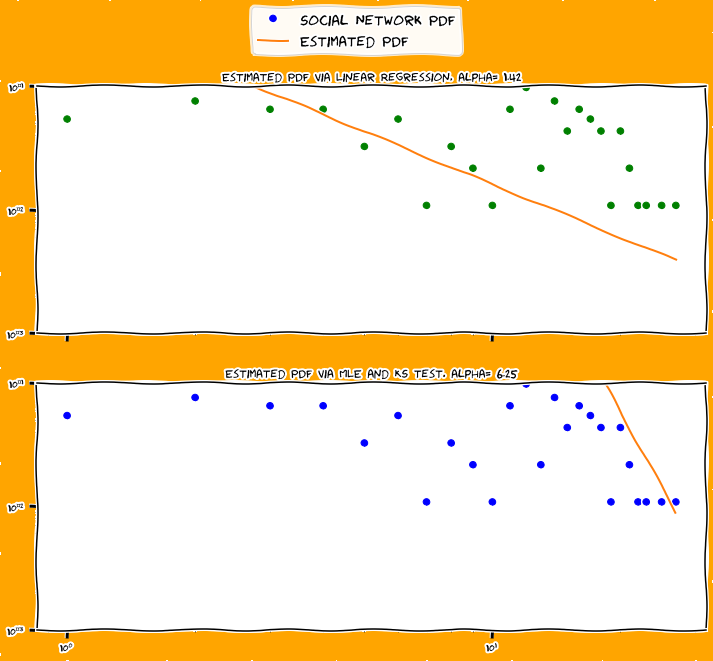

In [28]:
bins = 100
degree_sequence = np.array(list(dict(nx.degree(gig_component)).values()))
x_min = degree_sequence.min()

binning = np.logspace(np.log10(x_min), np.log10(degree_sequence.max()), bins)
hist, bin_edges = np.histogram(degree_sequence, bins=binning, density=True)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
x_space = np.linspace(x_min, degree_sequence.max(), 100)


plt.figure(figsize=(12, 10))   
plt.rcParams['axes.grid'] = False
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(12, 10), facecolor='orange')


ax1.loglog(np.arange(0, len(pdf)), 
           pdf, 
           color='green', 
           marker='o', 
           linestyle='None',
           label='Social Network PDF')
hat_alpha_reg = alpha_log_bins(degree_sequence, bins)
ax1.loglog(x_space, power_law_pdf(x_space, hat_alpha_reg, x_min), 
         label='Estimated PDF', c='tab:orange')
ax1.set_title('Estimated PDF via Linear Regression, alpha= {:.2f}'.format(hat_alpha_reg))
ax1.set_ylim(0.001, 0.1)
        
ax2.loglog(np.arange(0, len(pdf)), 
           pdf, 
           color='blue', 
           marker='o', 
           linestyle='None',
           label='Social Network PDF')
hat_alpha, hat_x_min = mle_power_law_params(degree_sequence)
ax2.loglog(x_space, power_law_pdf(x_space, hat_alpha, hat_x_min), 
         label='Estimated PDF', c='tab:orange')
ax2.set_title('Estimated PDF via MLE and KS test, alpha= {:.2f}'.format(hat_alpha))
ax2.set_ylim(0.001, 0.1)
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', prop={'size': 15})

plt.show()

8.   Gorgeous network layout.

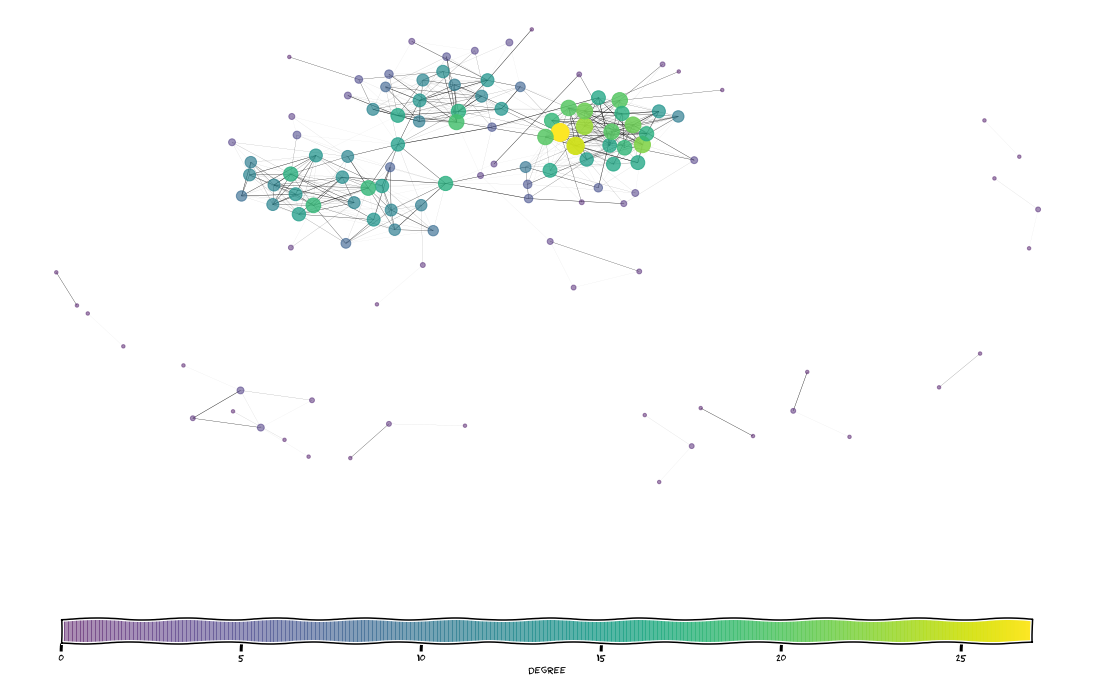

In [29]:
node_degree = nx.degree(G)
norm = plt.Normalize(0, max(dict(node_degree).values()))
cmap = customized_color('viridis', 0.45)
node_colors = [cmap(norm(dict(node_degree)[node])) for node in G.nodes]

elem = list(G.degree)
node_sizes, edge_width_list = [], []
for e in elem:
  edge_width_list.append(e[1])
  node_sizes.append(e[1] * 12)

edge_width = ((edge_width_list/np.max(edge_width_list))/2) + 0.02


plt.figure(figsize=(15, 10))
df_g = pos_layout(G)
pos = nx.kamada_kawai_layout(G, dist=df_g.to_dict())
nx.draw(G, 
        node_color=node_colors, 
        pos=pos, 
        node_size=node_sizes,
        width=edge_width)
plt.colorbar(ScalarMappable(cmap=cmap, norm=norm), 
             label='Degree', 
             shrink=0.9,
             aspect=40,
             orientation="horizontal")
plt.show()

Number of friends divided by gender:
Male: 139
Female: 29
Not Defined: 3

[(1, 139), (2, 29), (0, 3)]


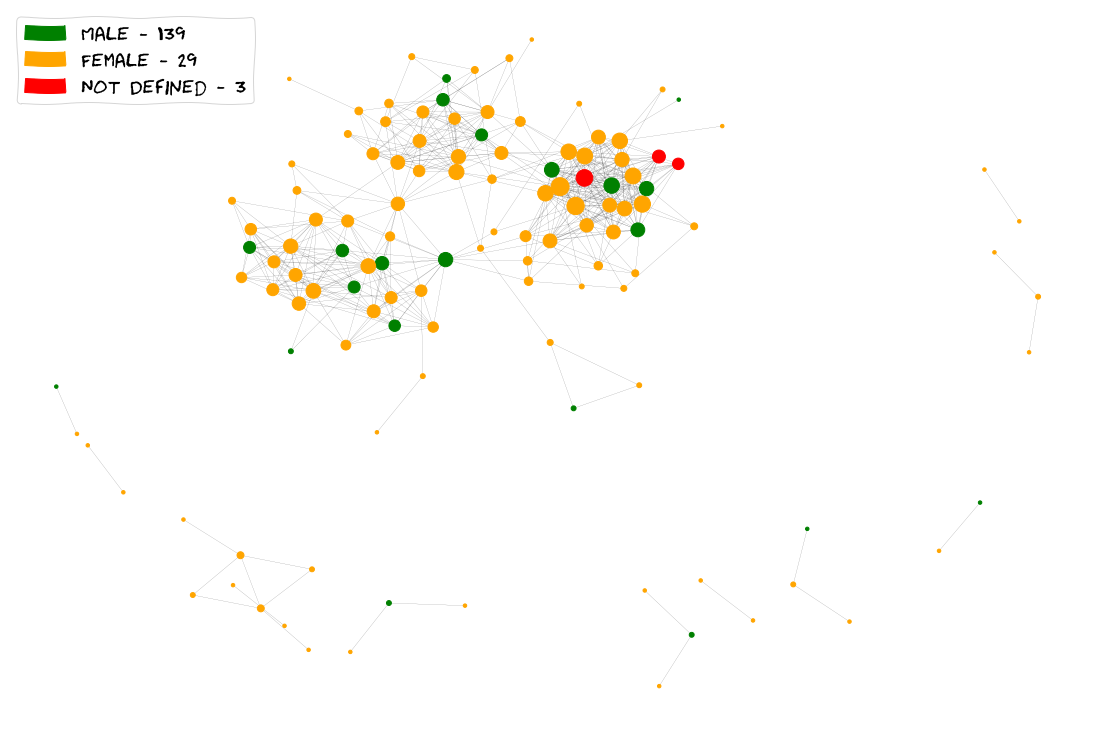

In [30]:
sex_info = Counter(nx.get_node_attributes(G,'sex').values()).most_common()
print('Number of friends divided by gender:')
print('Male:', sex_info[0][1])
print('Female:',sex_info[1][1])
print('Not Defined:',sex_info[2][1])
print("")
print(sex_info)

node_sex = nx.get_node_attributes(G,'sex') 
node_colors = []
for node in G.nodes:
  if node_sex[node] == 1:
    node_colors.append('orange')
  elif node_sex[node] == 0:
    node_colors.append('red')
  else:
    node_colors.append('green')

plt.figure(figsize=(15, 10))
df_g = pos_layout(G)
pos = nx.kamada_kawai_layout(G, dist=df_g.to_dict())
nx.draw(G, 
        node_color=node_colors,
        pos=pos, 
        node_size=node_sizes,
        width=0.1)
purple_patch = mpatches.Patch(color='green', label='Male - '+str(sex_info[0][1]))
yellow_patch = mpatches.Patch(color='orange', label='Female - '+str(sex_info[1][1]))
red_patch = mpatches.Patch(color='red', label='Not Defined - '+str(sex_info[2][1]))

plt.legend(handles=[purple_patch, yellow_patch, red_patch], fontsize=20, loc='upper left')

plt.show()